In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import re
# import xgboost as xgb
# import plotly.offline as py

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve, GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Load & Check

In [2]:
train_df = pd.read_csv("./Data/train.csv")
test_df = pd.read_csv("./Data/test.csv")
full_data = [train_df, test_df]

print("train df")
display(train_df.head(3))
display(train_df.tail(3))

print("\ntest df")
display(test_df.head(3))
display(test_df.tail(3))

train df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q



test df


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [3]:
print(train_df.info())
print()
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null

# Feature Engineering

In [4]:
PassengerID = test_df["PassengerId"]

우리가 목표하는 것은 특성값들을 바탕으로 결과(사고에서의 생존여부)를 예측하는 것이다.

그렇다면 어떤 특성이 생존여부와 관계가 큰 지를 아는 것이 중요하다.(상관관계가 높은 특성 추출)

이를 확인해보기 위해 가장 기본적으로 각 칼럼과 생존여부를 직접 비교해보자

###### Name Length

In [5]:
train_df["Name_len"] = train_df["Name"].apply(len)
test_df["Name_len"] = test_df["Name"].apply(len)

###### Has Cabin

In [6]:
train_df["Has_Cabin"] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1) # nan 값의 data type 은 float
test_df["Has_Cabin"] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

###### Pclass

In [7]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index = False).mean()
#as_index = False 를 하게 되면 기준이 되는 칼럼이 인덱스로 되지 않고 칼럼으로 나오게 된다.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


해당 결과값을 통해 직관적으로 Pclass가 높을수록(3 -> 1) 생존한 사람의 비율이 높은 것을 확인할 수 있다.

###### Sex

In [8]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


여성들의 생존율이 더 높은 것을 확인할 수 있다.

###### SibSp and Parch

위 특성은 형제자매의 수와 부모자식 수의 두 가지 특성이다. 해당 특성들의 경우 가족의 규모라는 하나의 특성으로 통합해서 다뤄볼 수 있다.

(통합해서 다룰 경우가 더 좋은 접근 방법인지는 직접 확인해 볼 여지가 있다. 다만, 여기선 해당 방법으로 데이터를 다뤄보겠다.)

In [9]:
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1 # 1을 더해주는 이유는 본인을 포함하기 위해서
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1

train_df[["FamilySize", "Survived"]].groupby(["FamilySize"], as_index = False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


위 작업에서는 가족의 규모에 따른 생존율을 확인해보았다. 여기서 더 나아가 가족과 함께 탄 사람과 혼자 탄 사람 사이의 생존율도 비교해보도록 하자

In [10]:
train_df["IsAlone"] = 0
train_df.loc[train_df["FamilySize"] == 1, "IsAlone"] = 1
# train_df.loc[train_df["FamilySize"] == 1]["IsAlone"] = 1  <- 같은 코드다.

test_df["IsAlone"] = 0
test_df.loc[test_df["FamilySize"] == 1, "IsAlone"] = 1

train_df[["IsAlone", "Survived"]].groupby(["IsAlone"], as_index = False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


###### Embarked

해당 칼럼은 각 승객들이 어떤 항구에서 배에 탑승했는지를 보여주는 값이다.

In [11]:
print(train_df["Embarked"].isnull().sum())

train_df["Embarked"].value_counts()

2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

null 값을 확인해보면 embarked 칼럼의 경우 2개의 null 값이 있는 것을 알 수 있다.

데이터의 분포를 살펴보면 대부분의 값이 'S' 값을 가지고 있으므로 null 값에 'S' 값을 부여해주도록 한다.

In [12]:
train_df["Embarked"] = train_df["Embarked"].fillna("S")

print(train_df[["Embarked", "Survived"]].groupby(["Embarked"], as_index = False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


###### Fare

Fare 값은 연속한 수치형 데이터이다. 연속형 데이터의 경우 일정한 범주로 데이터를 구분하여 범주형 데이터 타입으로 바꿔주는 접근법도 고려해볼 수 있다.

In [13]:
print(train_df["Fare"].isnull().sum())
print(test_df["Fare"].isnull().sum())

0
1


In [14]:
test_df["Fare"] = test_df["Fare"].fillna(train_df["Fare"].median())

In [15]:
train_df["Fare"].value_counts().sort_index()

0.0000      15
4.0125       1
5.0000       1
6.2375       1
6.4375       1
6.4500       1
6.4958       2
6.7500       2
6.8583       1
6.9500       1
6.9750       2
7.0458       1
7.0500       7
7.0542       2
7.1250       4
7.1417       1
7.2250      12
7.2292      15
7.2500      13
7.3125       1
7.4958       3
7.5208       1
7.5500       4
7.6292       1
7.6500       4
7.7250       1
7.7292       1
7.7333       4
7.7375       2
7.7417       1
            ..
80.0000      2
81.8583      1
82.1708      2
83.1583      3
83.4750      2
86.5000      3
89.1042      2
90.0000      4
91.0792      2
93.5000      2
106.4250     2
108.9000     2
110.8833     4
113.2750     3
120.0000     4
133.6500     2
134.5000     2
135.6333     3
146.5208     2
151.5500     4
153.4625     3
164.8667     2
211.3375     3
211.5000     1
221.7792     1
227.5250     4
247.5208     2
262.3750     2
263.0000     4
512.3292     3
Name: Fare, Length: 248, dtype: int64

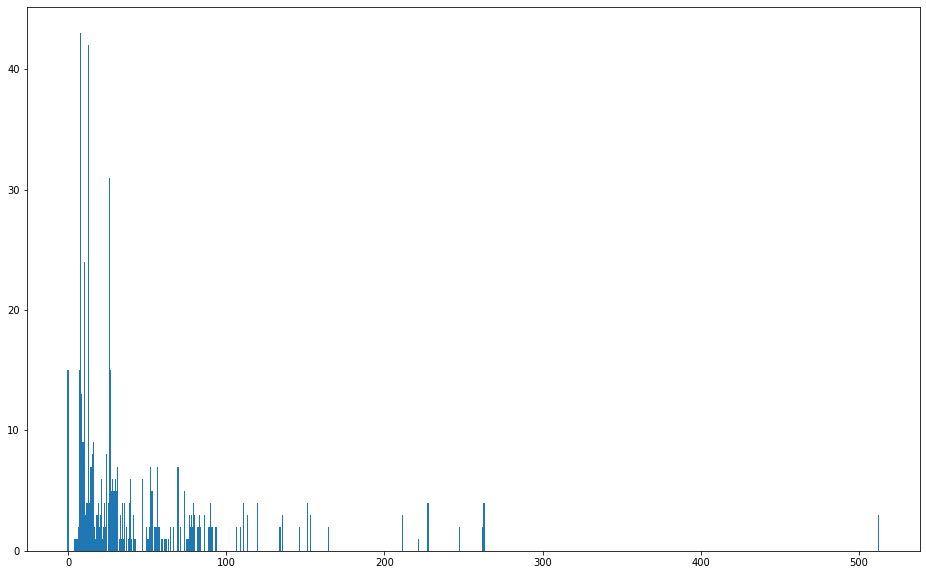

In [16]:
x = train_df["Fare"].value_counts().sort_index().index
y = train_df["Fare"].value_counts().sort_index().values

plt.figure(figsize = (16, 10))

plt.bar(x, y)

plt.show()

In [17]:
train_df["CategoricalFare"] = pd.qcut(train_df["Fare"], 4)
# 분위수로 나눠주는 기능. 각 구간별로 같은 수의 데이터가 담긴다.

print(train_df["CategoricalFare"].value_counts())
display(train_df[["CategoricalFare", "Survived"]].groupby(["CategoricalFare"], as_index = False).mean())

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: CategoricalFare, dtype: int64


,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


###### Age

많은 수의 missing value(null 값)을 가지고 있다. 어떤 값으로 해당 데이터를 채워줄 것인지 고민해봐야한다.

데이터의 분포를 확인해보면 눈에 띄는 이상치가 없는 것을 볼 수 있다. 그러므로 데이터를 가장 잘 표현하는 값이 평균이라고 가정할 수 있다.

우리는 평균에서 표준 편차범위 내에 있는 값들에서 랜덤으로 값을 추출하여 null 값에 부여해주도록 하겠다,

In [18]:
train_df["Age"].isnull().sum()

177

<BarContainer object of 88 artists>

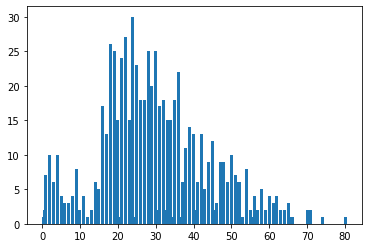

In [19]:
x = train_df["Age"].value_counts().sort_index().index
y = train_df["Age"].value_counts().sort_index().values

plt.bar(x, y)

In [20]:
age_avg = train_df["Age"].mean()
age_std = train_df["Age"].std()
age_null_count = train_df["Age"].isnull().sum()

age_null_value_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)

In [21]:
train_df["Age"][np.isnan(train_df["Age"])] = age_null_value_list
train_df["Age"] = train_df["Age"].astype(int)

train_df["CategoricalAge"] = pd.cut(train_df["Age"], 5)
#qcut을 쓸 때와 cut을 쓸 때의 구분

display(train_df[["CategoricalAge", "Survived"]].groupby(["CategoricalAge"], as_index = False).mean())

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.530973
1,"(16.0, 32.0]",0.350797
2,"(32.0, 48.0]",0.374517
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [22]:
age_avg = test_df["Age"].mean()
age_std = test_df["Age"].std()
age_null_count = test_df["Age"].isnull().sum()

age_null_value_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)

In [23]:
test_df["Age"][np.isnan(test_df["Age"])] = age_null_value_list
test_df["Age"] = test_df["Age"].astype(int)

###### Name

단순히 사람의 이름만 있는게 아니라, 사람들의 title도 존재한다.

In [24]:
display(train_df["Name"].head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [25]:
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    # title의 경우 앞에 공백과 마지막에 .으로 끝나기 때문에 정규표현식을 이용해 해당 부분을 추출할 수 있다.
    
    if title_search:
        return title_search.group(1)
    
    return ""

train_df["Title"] = train_df["Name"].apply(get_title)
test_df["Title"] = test_df["Name"].apply(get_title)

display(pd.crosstab(train_df["Title"], train_df["Sex"]))

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [26]:
train_df["Title"] = train_df["Title"].replace(["Lady", "Countess", "Capt", "Col",\
                                              "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
train_df["Title"] = train_df["Title"].replace("Mlle", "Miss")
train_df["Title"] = train_df["Title"].replace("Ms", "Miss")
train_df["Title"] = train_df["Title"].replace("Mme", "Mrs")

test_df["Title"] = test_df["Title"].replace(["Lady", "Countess", "Capt", "Col",\
                                              "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
test_df["Title"] = test_df["Title"].replace("Mlle", "Miss")
test_df["Title"] = test_df["Title"].replace("Ms", "Miss")
test_df["Title"] = test_df["Title"].replace("Mme", "Mrs")

display(train_df[["Title", "Survived"]].groupby(["Title"], as_index = False).mean())

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Data Cleaning

data들의 일차적인 전처리 작업이 끝났다. 이제 범주형 데이터 등 숫자로 표현되지 않은 데이터들을 숫자형 데이터 값으로 맵핑해주는 작업을 해야한다.

In [27]:
for df in full_data:
    # Mapping Sex, map 메서드의 활용
    df["Sex"] = df["Sex"].map({"female": 0, "male": 1}).astype(int)
    
    # Mapping Title
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df["Title"] = df["Title"].map(title_mapping)
    df["Title"] = df["Title"].fillna(0)
    
    # Mapping Embarked
    df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    
    # Mapping Fare
    df.loc[df["Fare"] <= 7.91, "Fare"] = 0
    df.loc[(df["Fare"] > 7.91) & (df["Fare"] <= 14.454), "Fare"] = 1
    df.loc[(df["Fare"] > 14.454) & (df["Fare"] <= 31), "Fare"] = 2
    df.loc[(df["Fare"] > 31), "Fare"] = 3
    df["Fare"] = df["Fare"].astype(int)
    
    # Mapping Age
    df.loc[df["Age"] <= 16, "Age"]
    df.loc[(df["Age"] > 16) & (df["Age"] <= 32), "Age"] = 1
    df.loc[(df["Age"] > 32) & (df["Age"] <= 48), "Age"] = 2
    df.loc[(df["Age"] > 48) & (df["Age"] <= 64), "Age"] = 3
    df.loc[df["Age"] > 64, "Age"] = 4

In [28]:
# Feature Selection

drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]

train_df = train_df.drop(drop_elements, axis = 1)
train_df = train_df.drop(["CategoricalAge", "CategoricalFare"], axis = 1)

test_df = test_df.drop(drop_elements, axis = 1)

display(train_df.head())

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_len,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


# Visualization

EDA 를 통한 데이터 전처리가 어느정도 진행된 후에는 적극적인 시각화의 활용이 필요하다. 시각화를 통해 훨씬 더 직관적으로 데이터를 이해할 수 있기 때문이다.

In [29]:
display(train_df.head())
print(train_df.shape)

display(test_df.head())
print(test_df.shape)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_len,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


(891, 12)


,Pclass,Sex,Age,Parch,Fare,Embarked,Name_len,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


(418, 11)


### Pearson Correlation Heatmap

피어슨 상관계수는 대표적으로 각 특성값들이 얼마나 결과값에 영향을 주는지 파악할 수 있게 도와주는 값이다. 히트맵을 통해서 다양한 변수들 간의 상관계수를 한 눈에 확인해볼 수 있다.

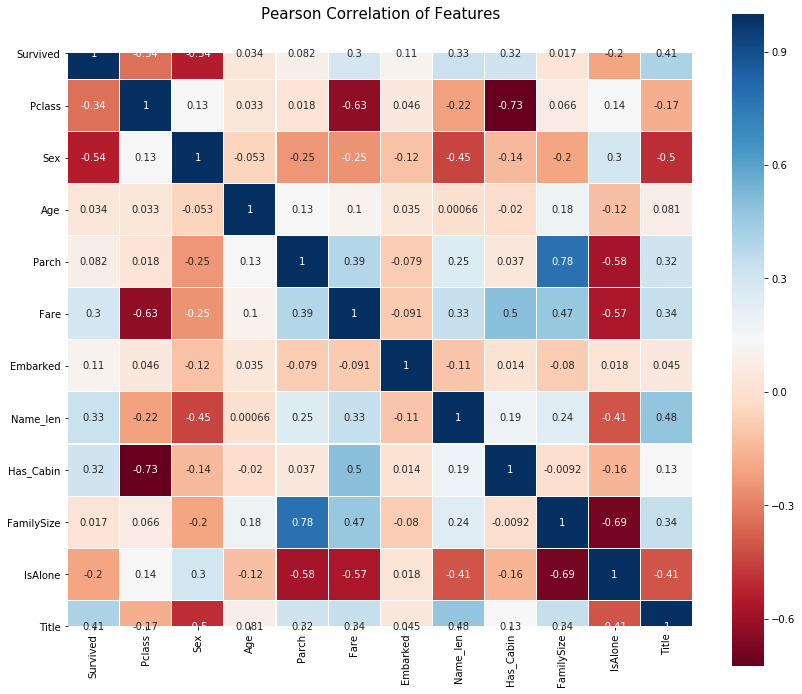

In [30]:
colormap = plt.cm.RdBu

plt.figure(figsize = (14, 12))

plt.title("Pearson Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train_df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True)

plt.show()

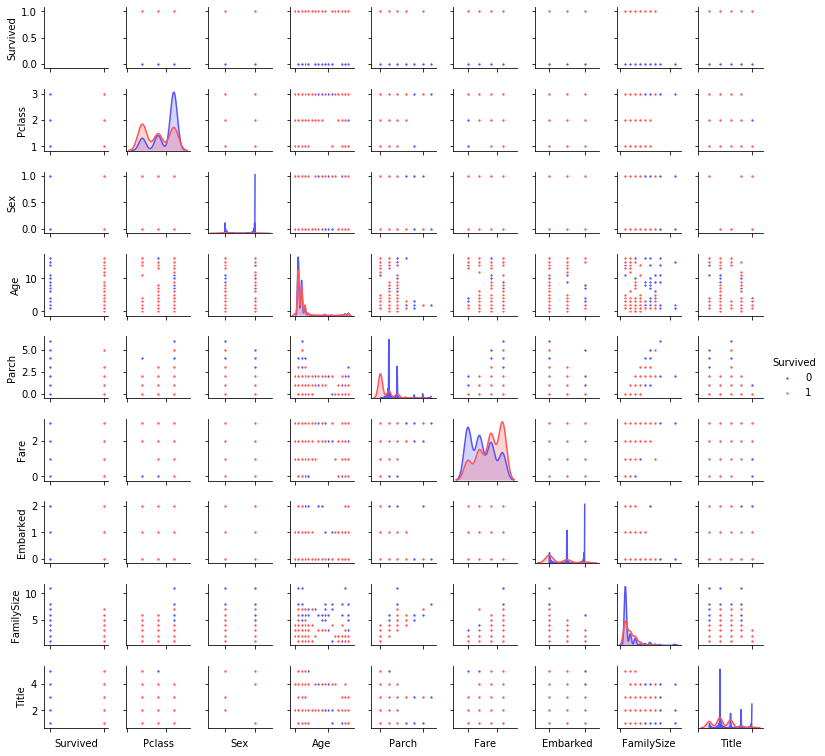

In [31]:
g = sns.pairplot(train_df[["Survived", "Pclass", "Sex", "Age", "Parch", "Fare", "Embarked", "FamilySize", "Title"]],
                hue = "Survived", palette = "seismic", size = 1.2, diag_kind = "kde", diag_kws = dict(shade = True), plot_kws = dict(s = 10))

g.set(xticklabels = [])

# Modeling

----------------------------------------------------------------------

### Stacking Ensemble

In [38]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]

random_seed = 0
n_folds = 5
kf = KFold(n_splits = n_folds, random_state = random_seed)

In [37]:
class SklearnHelper():
    def __init__(self, clf, seed = 0, params = None):
        params["random_state"] = seed
        self.clf = clf(**params)
        
    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self, X, y):
        return self.clf.fit(X, y)
    
    def feature_importances(self, X, y):
        print(self.clf.fit(X, y).feature_importances_)

### Out-of_Fold Predictions

In [57]:
def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((n_train, ))
    oof_test = np.zeros((n_test, ))
    oof_test_skf = np.empty((n_folds, n_test))
    
    for i, (train_index, test_index) in enumerate(kf):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]
        
        clf. train(X_tr, y_tr)
        
        oof_train[test_index] = clf.predict(X_te)
        oof_test_skf[i, :] = clf.predict(X_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0)
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Generating our Base First - Level Models

1. Random Forest Classifier
2. Extra Trees Classifier
3. AdaBoost Classifier
4. Gradient Boosting Classifier
5. Support Vector Machine

In [40]:
RF_params = {"n_jobs": -1, "n_estimators": 500, "warm_start": True, "max_depth": 6, "min_samples_leaf": 2,
            "max_features": "sqrt", "verbose": 0}

ET_params = {"n_jobs": -1, "n_estimators": 500, "max_depth": 8, "min_samples_leaf": 2, "verbose": 0}

Ada_params = {"n_estimators": 500, "learning_rate": 0.75}

GB_params = {"n_estimators": 500, "max_depth": 5, "min_samples_leaf": 2, "verbose": 0}

SVC_params = {"kernel": "linear", "C": 0.025}

In [42]:
RF = SklearnHelper(clf = RandomForestClassifier, seed = random_seed, params = RF_params)
ET = SklearnHelper(clf = ExtraTreesClassifier, seed = random_seed, params = ET_params)
Ada = SklearnHelper(clf = AdaBoostClassifier, seed = random_seed, params = Ada_params)
GB = SklearnHelper(clf = GradientBoostingClassifier, seed = random_seed, params = GB_params)
SVC = SklearnHelper(clf = SVC, seed = random_seed, params = SVC_params)

In [54]:
X_train = train_df[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_len', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']].values
X_test = test_df.values

y_train = train_df["Survived"].ravel()

In [65]:
cv_result = cross_val_score(RandomForestClassifier(n_estimators = 500, max_depth = 6, min_samples_leaf = 2), X_train, y_train, cv = kf, scoring = "accuracy")

In [70]:
cv_result.feature_importances_

AttributeError: 'numpy.ndarray' object has no attribute 'feature_importances_'

In [71]:
RandomForestClassifier.fit(X_train, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

-----------------------------------------------------------------------------------------

In [80]:
X_train = train_df[['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_len', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']].values
X_test = test_df.values

y_train = train_df["Survived"].ravel()

### Simple Modeling

1. SVC
2. Decision Tree
3. AdaBoost
4. Random Forest
5. Extra Trees
6. Gradient Boosting
7. Multiple layer perceptron(NN)
8. KNN
9. Logistic Regression
10. Linear Discriminant Analysis

In [83]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

kfold = StratifiedKFold(n_splits = 10)

In [99]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state),
                                      random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = [] # cv 는 cross validation을 의미
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = "accuracy", cv = kfold))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValErrors": cv_std,
                       "Algorithm": ["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting", 
                                     "MultipleLayerPerceptron", "KNeighbors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

Text(0.5, 1.0, 'Cross validation scores')

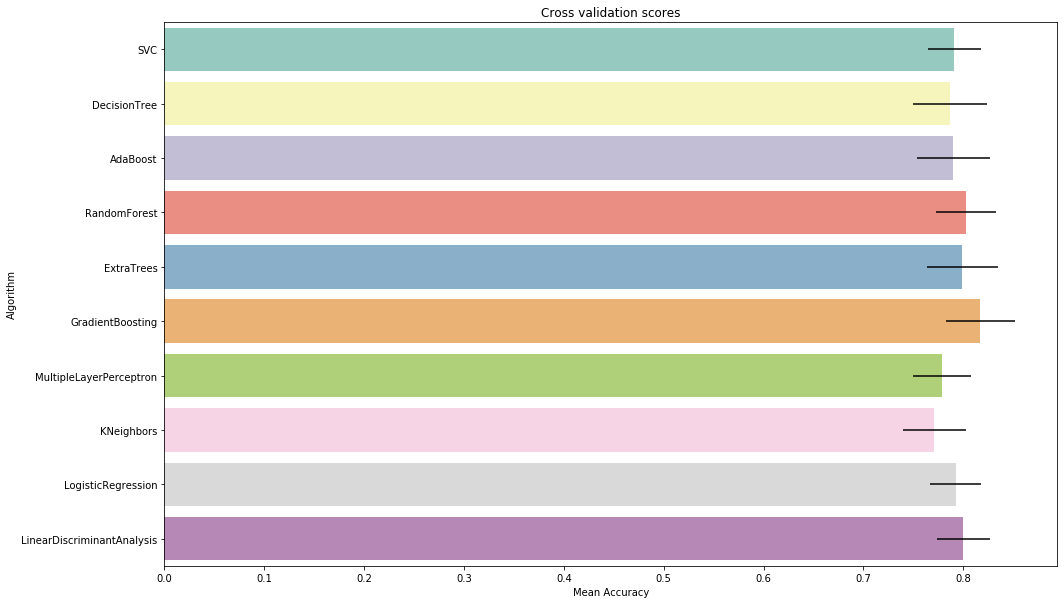

In [110]:
plt.figure(figsize = (16, 10))

sns.barplot("CrossValMeans", "Algorithm", data = cv_res,
           palette = "Set3", orient = "h", **{"xerr": cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

### Hyperparameter Tunning

SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 모델을 이용해 앙상블 모델을 만들어보도록 하겠다.

###### AdaBoost

In [117]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"],
                 "base_estimator__splitter": ["best", "random"],
                 "algorithm": ["SAMME", "SAMME.R"], "n_estimators": [1, 2],
                 "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold,
                       scoring = "accuracy", verbose = 1)

gsadaDTC.fit(X_train, y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1120 out of 1120 | elapsed:    6.4s finished


In [118]:
gsadaDTC.best_score_

0.7901234567901234

###### ExtraTrees

In [119]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None], "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10], "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False], "n_estimators": [100, 300], "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = "accuracy", verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.4min finished


In [120]:
gsExtC.best_score_

0.8271604938271605

###### RFC

In [123]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None], "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10], "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False], "n_estimators": [100, 300], "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold,
                    scoring = "accuracy", verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.0min finished


In [124]:
gsRFC.best_score_

0.8305274971941639

###### Gradient Boosting

In [125]:
GBC = GradientBoostingClassifier()

gb_param_grid = {"loss": ["deviance"], "n_estimators": [100, 200, 300],
                "learning_rate": [0.1, 0.05, 0.01], "max_depth": [4, 8],
                "min_samples_leaf": [100, 150], "max_features": [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold,
                    scoring = "accuracy", verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.6min finished


In [126]:
gsGBC.best_score_

0.8181818181818182

###### SVC

In [128]:
SVMC = SVC(probability = True)

svc_param_grid = {"kernel": ["rbf"], "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold,
                     scoring = "accuracy", verbose = 1)

gsSVMC.fit(X_train, y_train)

SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  1.3min finished


In [129]:
gsSVMC.best_score_

0.8159371492704826

### Plot Learning Curves

In [130]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure(figsize = (10, 6))
    
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, "o-", color = "r", label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, "o-", color = "g", label = "Cross Validation score")
    
    plt.legend(loc = "best")
    
    return plt

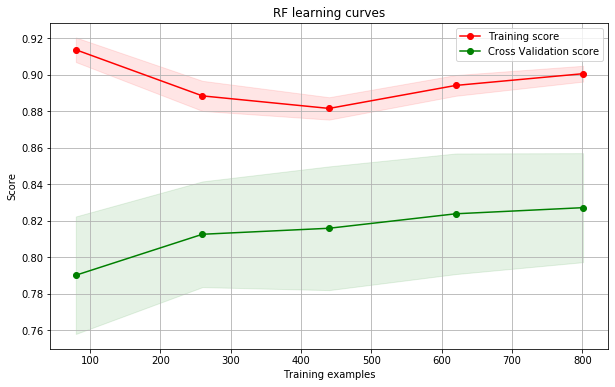

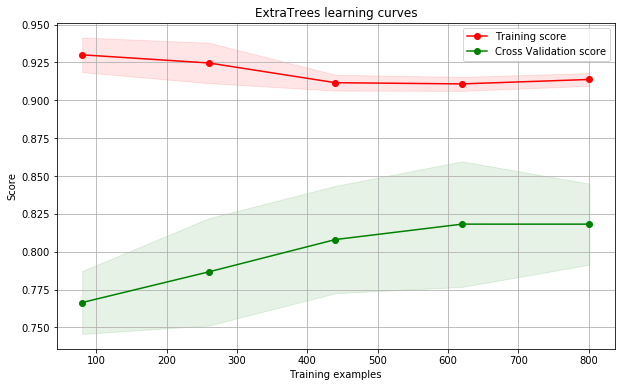

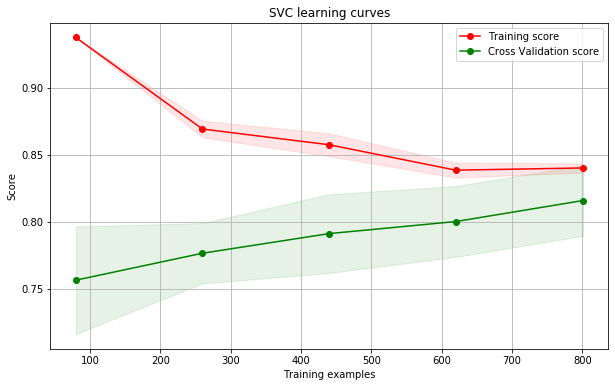

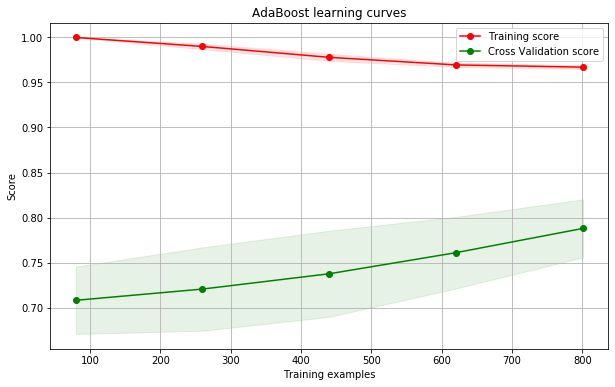

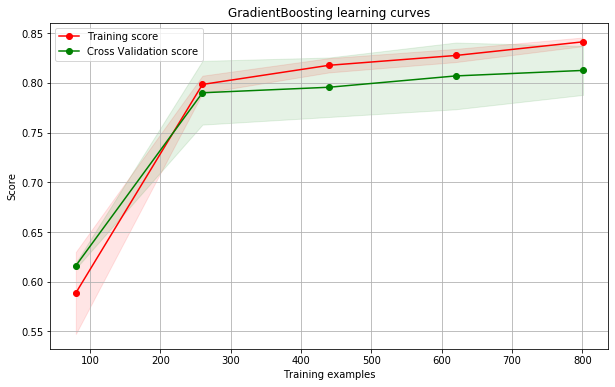

In [132]:
g = plot_learning_curve(gsRFC.best_estimator_, "RF learning curves", X_train, y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train, y_train, cv=kfold)

### Feature Importance

각 모델 별로 어떤 특성값이 학습에 중요한 영향을 끼쳤는지 확인해보자

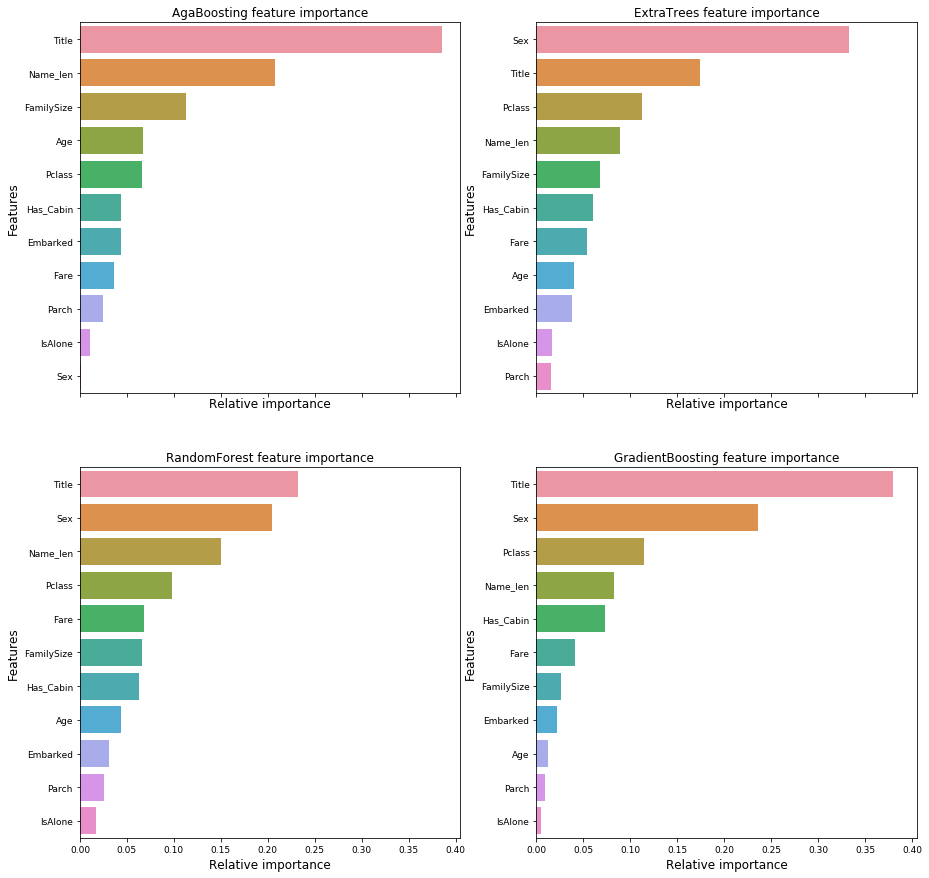

In [144]:
nrows = ncols = 2

fig, axes = plt.subplots(nrows = nrows , ncols = ncols, sharex = "all", figsize = (15, 15))

names_classifiers = [("AgaBoosting", ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1]
        
        g = sns.barplot(x = classifier.feature_importances_[indices],
                       y = train_df.columns[1:][indices], orient = "h", ax = axes[row][col])
        g.set_xlabel("Relative importance", fontsize = 12)
        g.set_ylabel("Features", fontsize = 12)
        g.tick_params(labelsize = 9)
        g.set_title(name + " feature importance")
        
        nclassifier += 1

We note that the four classifiers have different top features according to the relative importance. It means that their predictions are not based on the same features. Nevertheless, they share some common important features for the classification , for example 'Fare', 'Title_2', 'Age' and 'Sex'.

According to the feature importance of this 4 classifiers, the prediction of the survival seems to be more associated with the Age, the Sex, the family size and the social standing of the passengers more than the location in the boat.

In [151]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name = "RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name = "ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name = "SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name = "Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name = "GBC")

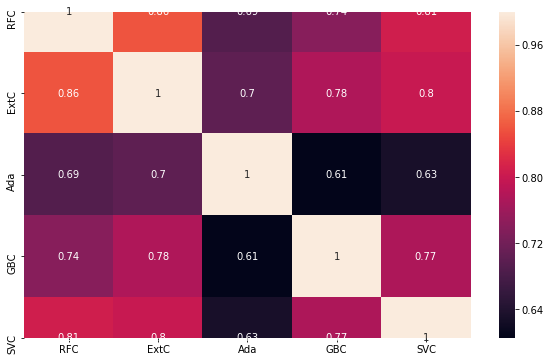

In [157]:
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC,
                             test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis = 1)

plt.figure(figsize = (10, 6))

sns.heatmap(ensemble_results.corr(), annot = True)

plt.show()

### Ensemble Modeling

In [158]:
votingC = VotingClassifier(estimators = [("rfc", RFC_best), ("extc", ExtC_best),
                                        ("svc", SVMC_best), ("adac", ada_best), ("gbc", GBC_best)],
                          voting = "soft") # hard voting 과 soft voting 의 차이 알기

votingC = votingC.fit(X_train, y_train)

In [165]:
test_Survived = pd.Series(votingC.predict(X_test), name = "Survived")

results = pd.concat([test_id, test_Survived], axis = 1)

In [167]:
results.to_csv("ensemble_python_voting.csv", index = False)